In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/julia/biomaths_julia_www"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: true
#| output: true
using DifferentialEquations

# conditions initiales
x0 = 1.0
y0 = 1.95
etat0 = [x0, y0]

# paramètres
r = 1.0
c = 1.0
b = 1.0
m = 1.0
par_lovo = [r, c, b, m]

# integration plus longue
tspan = (0.0, 30.0)
tstep = .01

# définition du modèle
function lovo(u, par, t)
    r, c, b, m = par
    x = u[1]
    y = u[2]
    dx = r*x - c*x*y
    dy = b*x*y - m*y
    [dx, dy]
end

# problème
prob_lovo = ODEProblem(lovo, etat0, tspan, par_lovo, saveat = tstep)
# intégration
sol_lovo = solve(prob_lovo, reltol = 1e-6)
sol_lovo[1,:]

3001-element Vector{Float64}:
 1.0
 0.9905452875414233
 0.9811817740609885
 0.9719103370837534
 0.962731777808045
 0.9536468229270878
 0.9446561264865978
 0.9357602717733164
 0.9269597732293241
 0.9182550783849169
 0.9096465698172779
 0.9011345671038459
 0.8927193287932835
 ⋮
 0.8682662215531705
 0.8732231912592429
 0.8782132528861987
 0.8832364546892432
 0.888292841827793
 0.8933824562653292
 0.8985053366671637
 0.9036615182961335
 0.9088510329061205
 0.9140739086334049
 0.9193301698858709
 0.9246198372298333

In [3]:
#| output: true
using CairoMakie

# on crée la figure avec un fond gris clair
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
              resolution = (1000, 700)) 

# déclare les différents panels comme des éléments gridlayout contenant les plots
panela = fig[1, 1] = GridLayout()
panelb = fig[2, 1] = GridLayout()
panelc = fig[:, 2] = GridLayout()

GridLayout[1:1, 1:1] with 0 children


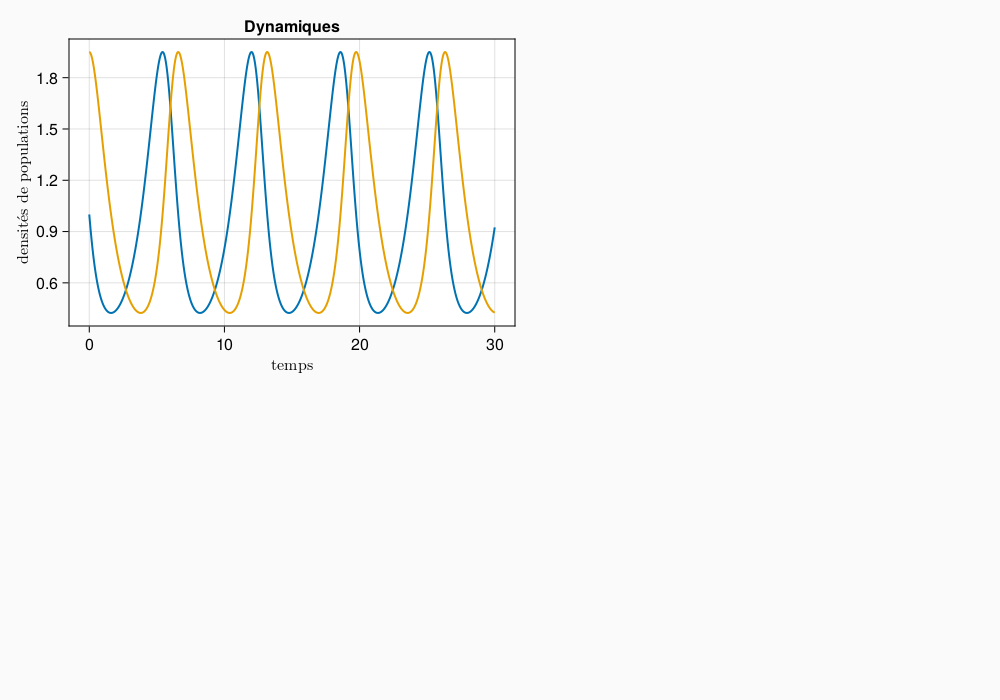

In [4]:
#| output: true
ax1 = Axis(panela[1,1],
           xlabel = L"temps$$",
           ylabel = L"densités de populations$$",
           title="Dynamiques")

lines!(ax1, sol_lovo.t, sol_lovo[1,:],
       linewidth = 2,
       label = L"$x(t)$")
lines!(ax1, sol_lovo.t, sol_lovo[2,:],
       linewidth = 2,
       label = L"$y(t)$")

fig

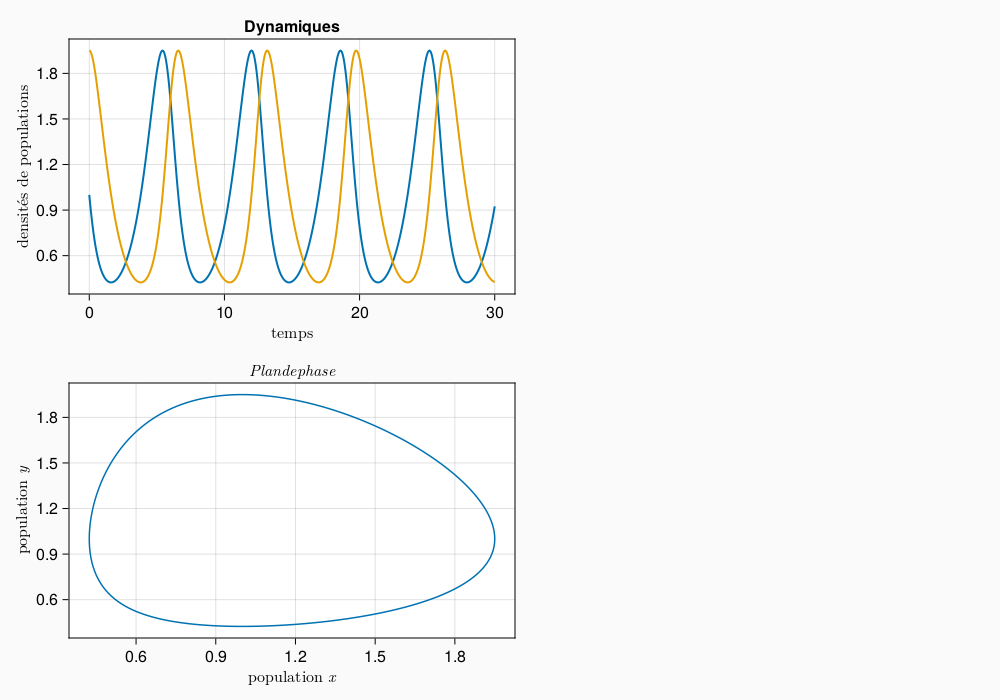

In [5]:
#| output: true
ax2 = Axis(panelb[1,1],
           xlabel = L"population $x$",
           ylabel = L"population $y$",
           title = L"Plan de phase")

lines!(ax2, sol_lovo[1, :], sol_lovo[2, :])

fig